# Cab Fare Prediction 

### Problem Statement
   #### To design a system that predicts the fare amount for a cab ride in the city

### Data Description
    You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected the historical data from your pilot project and now have a requirement to apply analytics for fare prediction. 

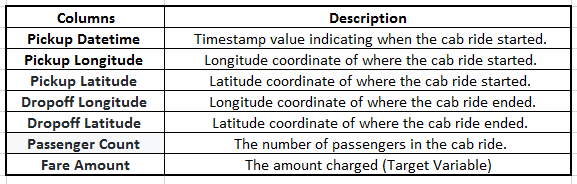

## Importing Packages

In [1]:
pip install pyforest        #Lazy import for all the libraries.

Note: you may need to restart the kernel to use updated packages.


Invalid requirement: '#Lazy'



In [2]:
from pyforest import *

In [3]:
d_train = pd.read_csv("C:/Users/Chinmayi/Desktop/EdWisor/Cab_Fare_Prediction/train_cab.csv")                       # Load in the data as 'dataset'


In [4]:
d_train.head()             # Returns first 5 rows of the data

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
d_train.shape                               # This returns the number of Columns and Rows (Observation) of the Dataset

(16067, 7)

In [6]:
d_train.columns                         # Returns the names of the columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [7]:
d_train.info()                          # Returns the # of values in each column with its datatype.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


#### The above information clearly depicts that there are 24 and 55 missing values in fare_amount and passenger_count variable respectively. 
#### Also, we have two columns (fare_amount,pickup_datetime) with object as a datatype and rest of the variables are of float64 datatype.

## Feature Engineering

Converting the object datatype of fare_amount variable to numeric:

In [8]:
d_train["fare_amount"] = pd.to_numeric(d_train["fare_amount"],errors = "coerce")  # errors=’coerce’ replaces all non-numeric values with NaN.

Also converting and separating the pickup_datetime Variable:

In [9]:
# 'pickup_datetime'has a row with value as 43. Hence dropping the row.
d_train =d_train.drop(d_train[d_train["pickup_datetime"]== '43'].index, axis=0)
d_train.shape
# Converting object datatype to datetime:
d_train['pickup_datetime'] =  pd.to_datetime(d_train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')


#### Separating pickup_datetime in Year,Month,Day,Day of Week, Hour,Minutes and Seconds

In [10]:
d_train['Year'] = d_train['pickup_datetime'].dt.year
d_train['Month'] = d_train['pickup_datetime'].dt.month
d_train['Date'] = d_train['pickup_datetime'].dt.day
d_train['Day'] = d_train['pickup_datetime'].dt.dayofweek
d_train['Hour'] = d_train['pickup_datetime'].dt.hour
d_train['Minute'] = d_train['pickup_datetime'].dt.minute

Thus, 6 new columns are added to the above dataset. Dropping the main column 'pickup_datetime'.

In [11]:
d_train.drop('pickup_datetime',axis=1,inplace=True)

###  Pre Processing Profiling
     We run a Pre Profiling on the data set which gives us information regarding the columns and detailed report regarding the coorelation between the variables. A detailed HTML report is generated which provides us with the visualization which further can be used for detailed analysis. 

In [12]:
 profile = d_train.profile_report(title='Cab Fare Prediction Profiling Report',style={'full_width':True})
profile.to_file(output_file="Cab_Fare_Prediction_PreProcessing_Profiling.html")

### Observation:
- __fare_amount__ value ranges from -3 to 54343.Thr data is highly skewed with skewness value as 125.40.
- __passenger_count__ value ranges from 0 to 5345 and skewness value as 84.61.
- __dropoff_latitude__ has 312 (1.9% of total data) zeros.
- __dropoff_longitude__ has 314 (2.0% of total data) zeros.
- __pickup_latitude__ has 315 (2.0% of total data) zeros.
- __pickup_longitude__ is highly correlated with dropoff_longitude with correlation value as 0.96. Hence this feature needs to rejected.

### Missing Values

In [13]:
d_train.isnull().sum()      # This returns the no of missing values.

fare_amount          25
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
Year                  0
Month                 0
Date                  0
Day                   0
Hour                  0
Minute                0
dtype: int64

Dropping 24+55=79 rows from dataset as there are missing values in fare_amount and passenger_count variables. 

In [14]:
d_train.dropna(subset=['fare_amount', 'passenger_count'], axis=0 ,inplace=True)
d_train.shape

(15986, 12)

#### We know that Longitude values needs to be in a range of -180 to 180 and Latitude values from -90 to 90. so dropping the values which are out of range.


In [15]:
# Getting rows for the not accepatable values.
d_train[d_train['pickup_latitude']<-90]
d_train[d_train['pickup_longitude']<-180]
d_train[d_train['pickup_longitude']>180]
d_train[d_train['dropoff_latitude']<-90]
d_train[d_train['dropoff_latitude']>90]
d_train[d_train['dropoff_longitude']<-180]
d_train[d_train['dropoff_longitude']>180]
d_train[d_train['pickup_latitude']>90]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Hour,Minute
5686,3.3,-73.947235,401.083332,-73.951392,40.778927,1.0,2011,7,30,5,11,15


#### Dropping one row with pickup_laatitude value as 401.77.

In [16]:
d_train = d_train.drop((d_train[d_train['pickup_latitude']>90]).index, axis=0)
d_train.shape

(15985, 12)

#### Calculating distance using __Haversine__ formula. This formula uses 4 variables i.e pickup_longitude,pickup latitude,dropoff_longitude and dropoff_latitude.

In [17]:
from math import radians, cos, sin, asin, sqrt

def haversine(a):
    lon1=a[0]
    lat1=a[1]
    lon2=a[2]
    lat2=a[3]
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km


#### Applying Formula

In [18]:
d_train['Distance'] = d_train[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)


#### Dropping off 'pickup_longitude','pickup_latitude','dropoff_longitude' and 'dropoff_latitude as their contribution in providing information which will be helpful  in predicting in target variable is already achieved. 

In [19]:
d_train.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1,inplace=True)


In [20]:
d_train.head()

,fare_amount,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance
0,4.5,1.0,2009,6,15,0,17,26,1.030764
1,16.9,1.0,2010,1,5,1,16,52,8.450134
2,5.7,2.0,2011,8,18,3,0,35,1.389525
3,7.7,1.0,2012,4,21,5,4,30,2.799270
4,5.3,1.0,2010,3,9,1,7,51,1.999157


In [21]:
d_train.describe()           # Returns detailed information about the spread of values in each column.

,fare_amount,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance
count,15985.000000,15985.000000,15985.000000,15985.000000,15985.000000,15985.000000,15985.000000,15985.000000,15985.000000
mean,15.031187,2.623373,2011.729184,6.262496,15.671692,3.034032,13.498592,29.643291,16.090257
std,431.227423,60.894043,1.864139,3.447869,8.682948,1.968748,6.521075,17.298537,325.635044
min,-3.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,15.000000,1.214650
50%,8.500000,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,30.000000,2.125326
75%,12.500000,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,45.000000,3.847022
max,54343.000000,5345.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,59.000000,8667.542104


### Observations:
- __fare_amount__ has minimum value as -3 and greatest value as 54343 which is not possible.
- __passenger_count__ has values ranging from 0 to 5345 which is also not acceptable. The value needs to be starting from 1.
- __distance__ has values from 0 to 8667.54. Need to work on them too.

In [22]:
# Counting values less than 1 to max 6 (as any cab accomodates maximum 7 persons) for passenger_count.
number=len(d_train[d_train["passenger_count"]> 6 ]) + len(d_train[d_train["passenger_count"] <1 ])
# 77 columns needs to be dropped.
d_train = d_train.drop(d_train[d_train["passenger_count"]<1 ].index, axis=0)
d_train = d_train.drop(d_train[d_train["passenger_count"]>6 ].index, axis=0)
d_train.shape


(15908, 9)

### Outlier Analysis for fare_amount and Distance

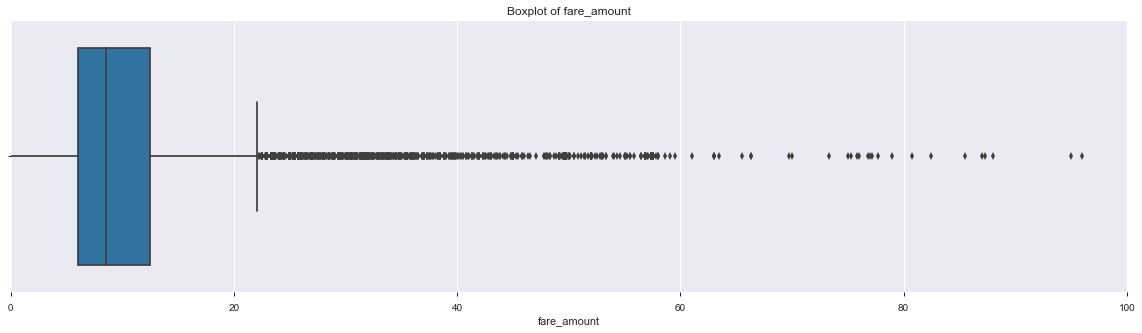

In [23]:
# Plotting a box plot as it is best to visualize outliers:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=d_train['fare_amount'],data=d_train,orient='h')
plt.title('Boxplot of fare_amount')
# plt.savefig('bp of fare_amount.png')
plt.show()

In [24]:
d_train['fare_amount'].sort_values()

13032       -3.00
2039        -2.90
2486        -2.50
10002        0.00
2780         0.01
1427         1.14
6632         2.50
12598        2.50
14633        2.50
4058         2.50
6703         2.50
11062        2.50
6765         2.50
14574        2.50
14530        2.50
12567        2.50
9621         2.50
11222        2.50
11153        2.50
4367         2.50
6297         2.50
6276         2.50
6226         2.50
1671         2.50
15257        2.50
3558         2.50
10111        2.50
6007         2.50
15370        2.50
9773         2.50
           ...   
9651        66.30
4118        69.70
1494        70.00
15023       73.30
13615       75.00
11019       75.33
10524       75.80
8363        76.00
6668        76.80
2013        77.00
13962       77.15
4013        77.70
2639        79.00
12437       80.75
14519       82.50
4620        85.50
12614       87.00
10077       87.30
9431        88.00
7810        95.00
12915       96.00
12349      104.67
14142      108.00
6630       128.83
1483      

fare_amount has 5 values less than 1 and 4 extreme values (434,453,4343,54343). These needs to br dropped. 

In [25]:
d_train = d_train.drop(d_train[d_train["fare_amount"]<1 ].index, axis=0)
d_train = d_train.drop(d_train[d_train["fare_amount"]>180 ].index, axis=0)
d_train.shape

(15899, 9)

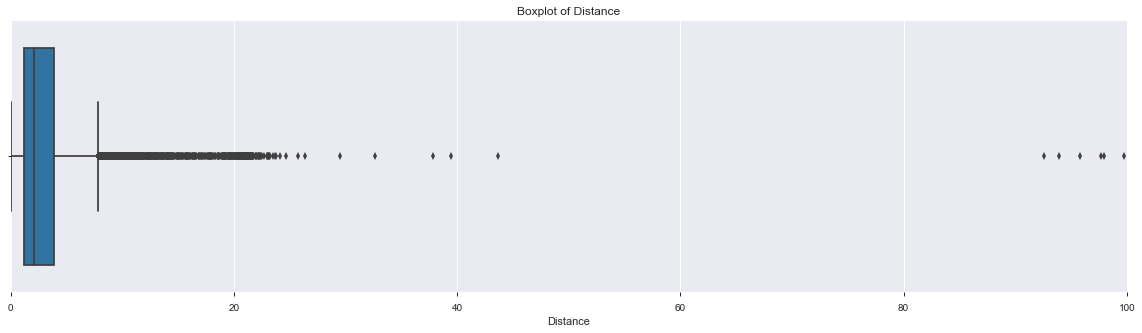

In [26]:
# Plotting a box plot as it is best to visualize outliers:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=d_train['Distance'],data=d_train,orient='h')
plt.title('Boxplot of Distance')
# plt.savefig('bp of fare_amount.png')
plt.show()


In [27]:
d_train['Distance'].sort_values(ascending=True)

11692       0.000000
4582        0.000000
12915       0.000000
12914       0.000000
4600        0.000000
8146        0.000000
4606        0.000000
10477       0.000000
8135        0.000000
8130        0.000000
10485       0.000000
728         0.000000
8123        0.000000
12882       0.000000
4653        0.000000
737         0.000000
10491       0.000000
4659        0.000000
4574        0.000000
2447        0.000000
2448        0.000000
10449       0.000000
4461        0.000000
13008       0.000000
15642       0.000000
8280        0.000000
13000       0.000000
4473        0.000000
8270        0.000000
657         0.000000
            ...     
3075       97.985088
1684       99.771579
5663      101.094619
12228     123.561157
11619     127.509261
14536     129.560455
10710     129.950482
7014     4447.086698
5864     5420.988959
2280     6026.494216
15749    6028.926779
15783    8656.714168
14197    8657.136619
12705    8661.362152
6302     8663.039123
12983    8664.131808
6188     8664

There are many rows with distance value as zero. Also last 22 rows have some very high values i.e above 4000 kms. These are not accepatble and hence needs to be dropped.

In [28]:
d_train = d_train.drop(d_train[d_train["Distance"]==0 ].index, axis=0)
d_train = d_train.drop(d_train[d_train["Distance"]>130 ].index, axis=0)
d_train.shape

(15422, 9)

In [29]:
d_train.describe()

,fare_amount,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance
count,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.00000,15422.000000,15422.000000
mean,11.315163,1.651945,2011.737777,6.273894,15.671897,3.035988,13.50000,29.668525,3.442879
std,9.472278,1.267718,1.870622,3.447881,8.684058,1.969665,6.50987,17.301541,4.597522
min,1.140000,1.000000,2009.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000111
25%,6.000000,1.000000,2010.000000,3.000000,8.000000,1.000000,9.00000,15.000000,1.277967
50%,8.500000,1.000000,2012.000000,6.000000,16.000000,3.000000,14.00000,30.000000,2.191322
75%,12.500000,2.000000,2013.000000,9.000000,23.000000,5.000000,19.00000,45.000000,3.937046
max,165.000000,6.000000,2015.000000,12.000000,31.000000,6.000000,23.00000,59.000000,129.950482


#### Applying Boolean type on 'Day' column to separate weekends and weekday.

In [30]:
d_train.head(10)

,fare_amount,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance
0,4.5,1.0,2009,6,15,0,17,26,1.030764
1,16.9,1.0,2010,1,5,1,16,52,8.450134
2,5.7,2.0,2011,8,18,3,0,35,1.389525
3,7.7,1.0,2012,4,21,5,4,30,2.799270
4,5.3,1.0,2010,3,9,1,7,51,1.999157
5,12.1,1.0,2011,1,6,3,9,50,3.787239
6,7.5,1.0,2012,11,20,1,20,35,1.555807
7,16.5,1.0,2012,1,4,2,17,22,4.155444
9,8.9,2.0,2009,9,2,2,1,11,2.849627
10,5.3,1.0,2012,4,8,6,7,30,1.374577


In [31]:
# 6 and 7 value corresponds to Saturday and Sunday.
d_train['Day'] = (d_train['Day'] <= 5).astype(int)

In [32]:
d_train.head(10)

,fare_amount,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance
0,4.5,1.0,2009,6,15,1,17,26,1.030764
1,16.9,1.0,2010,1,5,1,16,52,8.450134
2,5.7,2.0,2011,8,18,1,0,35,1.389525
3,7.7,1.0,2012,4,21,1,4,30,2.799270
4,5.3,1.0,2010,3,9,1,7,51,1.999157
5,12.1,1.0,2011,1,6,1,9,50,3.787239
6,7.5,1.0,2012,11,20,1,20,35,1.555807
7,16.5,1.0,2012,1,4,1,17,22,4.155444
9,8.9,2.0,2009,9,2,1,1,11,2.849627
10,5.3,1.0,2012,4,8,0,7,30,1.374577


#### 1 value represents weekday and 0 as weekends.

### Post Processing Profiling

In [33]:
profile = d_train.profile_report(title='Cab Fare Prediction Post Profiling Report',style={'full_width':True})
profile.to_file(output_file="Cab_Fare_Prediction_PostProcessing_Profiling.html")

### Visualizations

Text(0.5, 1.0, 'Correlation between features')

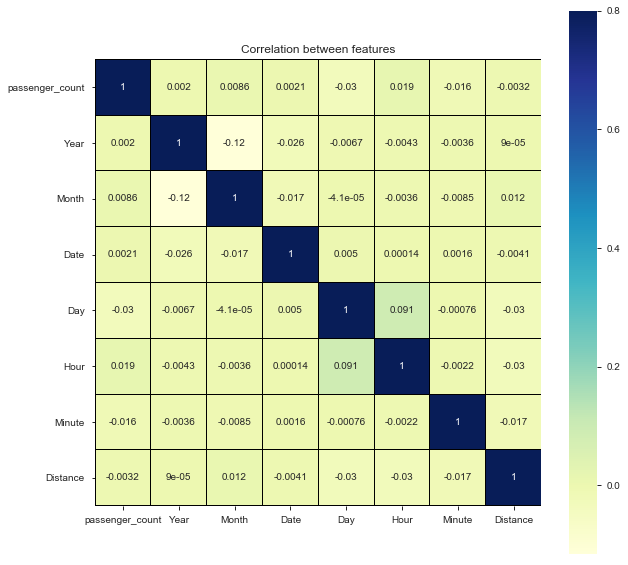

In [34]:
# Plotting a heatmap excluding target variable.
corr = d_train[d_train.columns[1:]].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.title('Correlation between features')

#### No Highly correlated features observed. 

### Yearwise Data Distribution

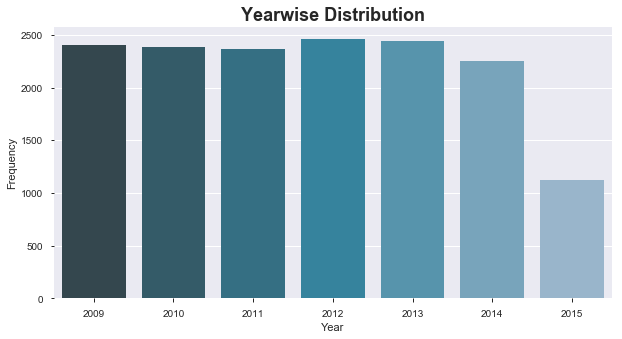

In [35]:
plt.figure(figsize=(10,5))
sns.countplot('Year',data = d_train,palette="PuBuGn_d")
plt.title("Yearwise Distribution",fontsize=18,fontweight="bold")
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

#### So most of the data belongs to 2009 to 2014 Year.

### Relationship between Distance and Fare Amount

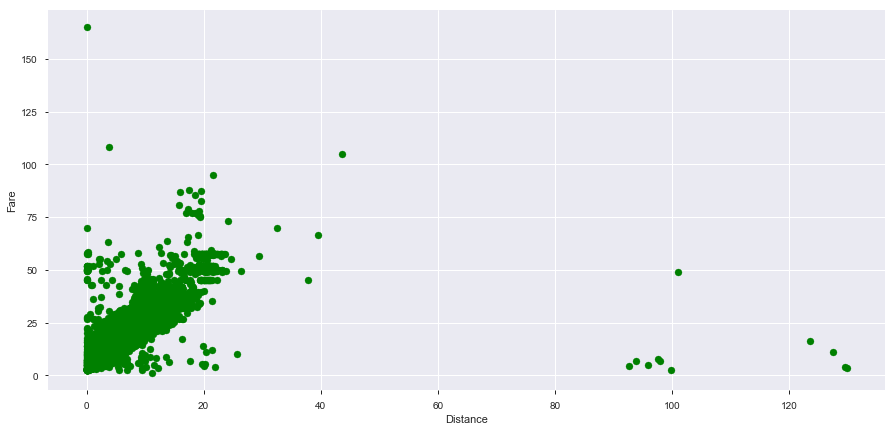

In [36]:
plt.figure(figsize=(15,7))
plt.scatter(x = d_train['Distance'],y = d_train['fare_amount'],c = "g")
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.show()

#### Thus, More the distance, more is the fare.

### Distribution of Data for all the variables 

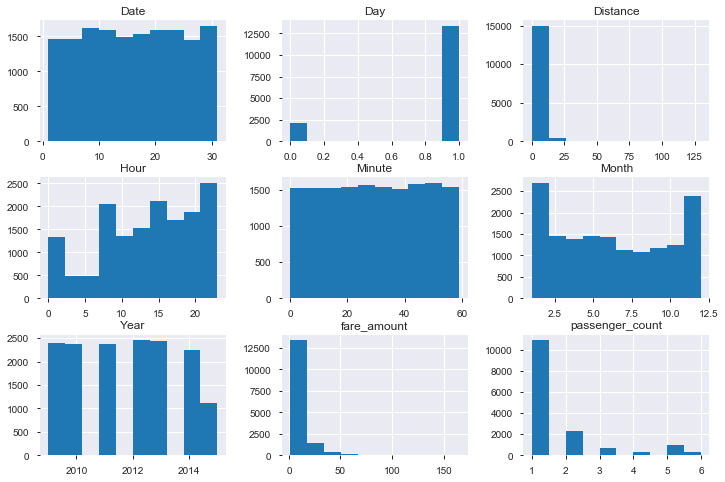

In [37]:
d_train.hist(figsize=(12, 8))
plt.show()

#### We can see that no data is normally distributed. We will need to scale the data.

### Impact of weekends and weekday on bookings.

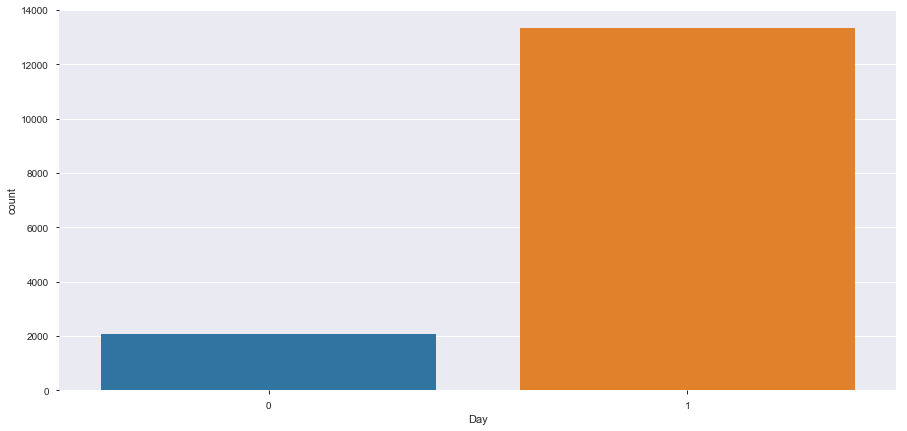

In [38]:
#impact of Day on the number of cab rides
plt.figure(figsize=(15,7))
sns.countplot(x="Day", data=d_train)

#### Thus cab bookings are more on weekdays as compared to weekends.

### Feature Scaling:

In [40]:
#since skewness of target variable is high, apply log transform to reduce the skewness-
d_train['fare_amount'] = np.log1p(d_train['fare_amount'])

#since skewness of distance variable is high, apply log transform to reduce the skewness-
d_train['Distance'] = np.log1p(d_train['Distance'])



In [41]:
# Seperating Data into X (Independant Variables) and Y (Dependant Variable)
X = d_train.iloc[:, d_train.columns != 'fare_amount'].values
y = d_train.iloc[:,d_train.columns == 'fare_amount'].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11566, 8)
(11566, 1)
(3856, 8)
(3856, 1)


### Model Building

### 1. Linear Regression Model

In [42]:
### from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
fit_LR = LinearRegression().fit(X_train , y_train)
#prediction on train data
pred_train_LR = fit_LR.predict(X_train)
#prediction on test data
pred_test_LR = fit_LR.predict(X_test)

##calculating MAE for train data
from sklearn import metrics
MAE_train = metrics.mean_absolute_error(y_train, pred_train_LR)
print('MAE for training set is {}'.format(MAE_train))
##calculating MAE for test data
MAE_test = metrics.mean_absolute_error(y_test, pred_test_LR)
print('MAE for test set is {}'.format(MAE_test))

##calculating MSE for train data
MSE_train = metrics.mean_squared_error(y_train, pred_train_LR)
print('MSE for training set is {}'.format(MSE_train))
##calculating MSE for test data
MSE_test = metrics.mean_squared_error(y_test, pred_test_LR)
print('MSE for test set is {}'.format(MSE_test))

##calculating RMSE for test data
from sklearn.metrics import mean_squared_error
RMSE_test_LR = np.sqrt(mean_squared_error(y_test, pred_test_LR))
print('Root Mean Squared Error value for test data using Linear Regression is:',format(RMSE_test_LR))  
##calculating RMSE for train data
RMSE_train_LR= np.sqrt(mean_squared_error(y_train, pred_train_LR))
print('Root Mean Squared Error value for train data using Linear Regression is:',format(RMSE_train_LR)) 

#calculate R^2  and Adjusted R^2 for train data
from sklearn.metrics import r2_score
r_squared=r2_score(y_train, pred_train_LR)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('R squared and Adjusted R squared value for train data using Linear Regression is:',(r_squared, adjusted_r_squared))
#calculate R^2  and Adjusted R^2 for test data
r_squared=r2_score(y_test, pred_test_LR)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('R squared and Adjusted R squared value for test data using Linear Regression is:',(r_squared, adjusted_r_squared))


MAE for training set is 0.05386055477531357
MAE for test set is 0.053744567418494496
MSE for training set is 0.006411516011483612
MSE for test set is 0.006443545447889028
Root Mean Squared Error value for test data using Linear Regression is: 0.08027169767663463
Root Mean Squared Error value for train data using Linear Regression is: 0.08007194272330109
R squared and Adjusted R squared value for train data using Linear Regression is: (0.7349940091812183, 0.7348105664256113)
R squared and Adjusted R squared value for test data using Linear Regression is: (0.7353831877207484, 0.7348329058132272)


### 2. Decision Tree Regressor

In [43]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(max_depth = 2)
DT.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [44]:
#prediction on train data
pred_train_DT = DT.predict(X_train)
#prediction on test data
pred_test_DT = DT.predict(X_test)

##calculating MAE for train data
from sklearn import metrics
MAE_train = metrics.mean_absolute_error(y_train, pred_train_DT)
print('MAE for training set is {}'.format(MAE_train))
##calculating MAE for test data
MAE_test = metrics.mean_absolute_error(y_test, pred_test_DT)
print('MAE for test set is {}'.format(MAE_test))

##calculating MSE for train data
MSE_train = metrics.mean_squared_error(y_train, pred_train_DT)
print('MSE for training set is {}'.format(MSE_train))
##calculating MSE for test data
MSE_test = metrics.mean_squared_error(y_test, pred_test_DT)
print('MSE for test set is {}'.format(MSE_test))

##calculating RMSE for test data
from sklearn.metrics import mean_squared_error
RMSE_test_DT = np.sqrt(mean_squared_error(y_test, pred_test_DT))
print('Root Mean Squared Error value for test data using Decision Tree Regressor is:',format(RMSE_test_DT))  
##calculating RMSE for train data
RMSE_train_DT= np.sqrt(mean_squared_error(y_train, pred_train_DT))
print('Root Mean Squared Error value for train data using Decision Tree Regressor is:',format(RMSE_train_DT)) 

#calculate R^2  and Adjusted R^2 for train data
from sklearn.metrics import r2_score
r_squared=r2_score(y_train, pred_train_DT)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('R squared and Adjusted R squared value for train data using Decision Tree Regressor is:',(r_squared, adjusted_r_squared))
#calculate R^2  and Adjusted R^2 for test data
from sklearn.metrics import r2_score
r_squared=r2_score(y_test, pred_test_DT)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('R squared and Adjusted R squared value for test data using Decision Tree Regressor is:',(r_squared, adjusted_r_squared))


MAE for training set is 0.06364241541824447
MAE for test set is 0.0633096244611148
MSE for training set is 0.007356985115132212
MSE for test set is 0.007235039482811506
Root Mean Squared Error value for test data using Decision Tree Regressor is: 0.08505903528027758
Root Mean Squared Error value for train data using Decision Tree Regressor is: 0.08577286934183916
R squared and Adjusted R squared value for train data using Decision Tree Regressor is: (0.6959151117485087, 0.6957046177530071)
R squared and Adjusted R squared value for test data using Decision Tree Regressor is: (0.7028789351857028, 0.7022610593035831)


### Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators = 200).fit(X_train,y_train)

In [46]:
#prediction on train data
pred_train_RF = RF.predict(X_train)
#prediction on test data
pred_test_RF = RF.predict(X_test)

In [47]:
##calculating MAE for train data
from sklearn import metrics
MAE_train = metrics.mean_absolute_error(y_train, pred_train_RF)
print('MAE for training set is {}'.format(MAE_train))
##calculating MAE for test data
MAE_test = metrics.mean_absolute_error(y_test, pred_test_RF)
print('MAE for test set is {}'.format(MAE_test))

##calculating MSE for train data
MSE_train = metrics.mean_squared_error(y_train, pred_train_RF)
print('MSE for training set is {}'.format(MSE_train))
##calculating MSE for test data
MSE_test = metrics.mean_squared_error(y_test, pred_test_RF)
print('MSE for test set is {}'.format(MSE_test))

##calculating RMSE for test data
from sklearn.metrics import mean_squared_error
RMSE_test_RF = np.sqrt(mean_squared_error(y_test, pred_test_RF))
print('Root Mean Squared Error value for test data using Random Forest Regressor is:',format(RMSE_test_RF))  
##calculating RMSE for train data
RMSE_train_RF= np.sqrt(mean_squared_error(y_train, pred_train_RF))
print('Root Mean Squared Error value for train data using Random Forest Regressor is:',format(RMSE_train_RF)) 

#calculate R^2  and Adjusted R^2 for train data
from sklearn.metrics import r2_score
r_squared=r2_score(y_train, pred_train_RF)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('R squared and Adjusted R squared value for train data using Random Forest Regressor is:',(r_squared, adjusted_r_squared))
#calculate R^2  and Adjusted R^2 for test data
from sklearn.metrics import r2_score
r_squared=r2_score(y_test, pred_test_RF)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('R squared and Adjusted R squared value for test data using Random Forest Regressor is:',(r_squared, adjusted_r_squared))


MAE for training set is 0.018659004301247062
MAE for test set is 0.05023343441919978
MSE for training set is 0.000745109246291421
MSE for test set is 0.005450285949570507
Root Mean Squared Error value for test data using Random Forest Regressor is: 0.07382605197063234
Root Mean Squared Error value for train data using Random Forest Regressor is: 0.02729668929176982
R squared and Adjusted R squared value for train data using Random Forest Regressor is: (0.9692025390363173, 0.9691812203820204)
R squared and Adjusted R squared value for test data using Random Forest Regressor is: (0.7761733341295461, 0.7757078770650898)


### Hyperparameter Tuning Using Random Forest Search Cross Validation 

In [48]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [50]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimator = list(range(1,20,2))
# Number of features to consider at every split
depth = list(range(5,15,2))
# Create the random grid
random_grid = {'n_estimators': n_estimator,
               'max_depth': depth}
pprint(random_grid)



{'max_depth': [5, 7, 9, 11, 13],
 'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}


In [51]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, random_state=0)
# Fit the random search model
randomcv_rf=rf_random.fit(X_train, y_train)
predictions_RRF = randomcv_rf.predict(X_test)
rf_random.best_params_


{'n_estimators': 17, 'max_depth': 9}

In [57]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(randomcv_rf, X_test, y_test)

#R^2
RRF_r2 = r2_score(y_test, predictions_RRF)
#Calculating RMSE
RRF_rmse = np.sqrt(mean_squared_error(y_test,predictions_RRF))
print('Random Search CV Random Forest Regressor Model Performance:')
print('R-squared = {:0.2}.'.format(RRF_r2))
print('RMSE = ',RRF_rmse)

Model Performance
Average Error: 0.1649 degrees.
Accuracy = 86.07%.
Random Search CV Random Forest Regressor Model Performance:
R-squared = 0.78.
RMSE =  0.07349476948593495


In [53]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random,  X_test, y_test)

Model Performance
Average Error: 0.1649 degrees.
Accuracy = 86.07%.


### Hyperparameter Tuning using Random Grid Search Cross Validation

In [82]:
from sklearn.model_selection import GridSearchCV    
## Grid Search CV for random Forest model
regr = RandomForestRegressor(random_state = 0)
n_estimator = list(range(11,20,1))
depth = list(range(5,15,2))

# Create the grid
grid = {'n_estimators': n_estimator,
               'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
rgs_rf = GridSearchCV(regr, param_grid = grid , cv = 5)
gdcv_rf = rgs_rf.fit(X_train,y_train)
best_params_GRF = gdcv_rf.best_params_

#Apply model on test data
predictions_grf = gdcv_rf.predict(X_test)


grid_accuracy = evaluate(gdcv_rf, X_test, y_test)


#R^2
GRF_r2 = r2_score(y_test, predictions_grf)
#Calculating RMSE
GRF_rmse = np.sqrt(mean_squared_error(y_test,predictions_grf))

print('Grid Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',best_params_GRF)
print('R-squared = {:0.2}.'.format(GRF_r2))
print('RMSE = ',(GRF_rmse))

Model Performance
Average Error: 0.1647 degrees.
Accuracy = 86.09%.
Grid Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'max_depth': 7, 'n_estimators': 17}
R-squared = 0.79.
RMSE =  0.07218859516980959


### Applying same operations as Training dataset on Test dataset:

In [58]:
d_test = pd.read_csv("C:/Users/Chinmayi/Desktop/EdWisor/Cab_Fare_Prediction/test.csv")                       # Load in the data as 'dataset'


In [59]:
d_test.shape    # Fetching the size of test dataset

(9914, 6)

In [60]:
d_test.columns  # Getting column names

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [61]:
d_test.info()      # Fetching info about datatypes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


In [62]:
d_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [63]:
d_test.head()   # Fetching first 5 rows

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [64]:
# Converting object datatype to datetime:
d_test['pickup_datetime'] =  pd.to_datetime(d_test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
d_test['Year'] = d_test['pickup_datetime'].dt.year
d_test['Month'] = d_test['pickup_datetime'].dt.month
d_test['Date'] = d_test['pickup_datetime'].dt.day
d_test['Day'] = d_test['pickup_datetime'].dt.dayofweek
d_test['Hour'] = d_test['pickup_datetime'].dt.hour
d_test['Minute'] = d_test['pickup_datetime'].dt.minute
d_test.drop('pickup_datetime',axis=1,inplace=True)


In [65]:
d_test.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Year', 'Month', 'Date', 'Day',
       'Hour', 'Minute'],
      dtype='object')

In [66]:
d_test.isnull().sum()      # This returns the no of missing values.


pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Year                 0
Month                0
Date                 0
Day                  0
Hour                 0
Minute               0
dtype: int64

#### Thus no missing values observed.

In [67]:
# Getting rows for the not accepatable values.
d_test[d_test['pickup_latitude']<-90]
d_test[d_test['pickup_longitude']<-180]
d_test[d_test['pickup_longitude']>180]
d_test[d_test['dropoff_latitude']<-90]
d_test[d_test['dropoff_latitude']>90]
d_test[d_test['dropoff_longitude']<-180]
d_test[d_test['dropoff_longitude']>180]
d_test[d_test['pickup_latitude']>90]


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Hour,Minute


In [68]:
d_test['Distance'] = d_test[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)
d_test.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1,inplace=True)
d_test.head()

,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance
0,1,2015,1,27,1,13,8,2.323259
1,1,2015,1,27,1,13,8,2.425353
2,1,2011,10,8,5,11,53,0.618628
3,1,2012,12,1,5,21,12,1.961033
4,1,2012,12,1,5,21,12,5.387301


In [69]:
# Counting values less than 1 to max 6 (as any cab accomodates maximum 7 persons) for passenger_count.
number=len(d_test[d_test["passenger_count"]> 6 ]) + len(d_test[d_test["passenger_count"] <1 ])
number

0

#### No values to be dropped.

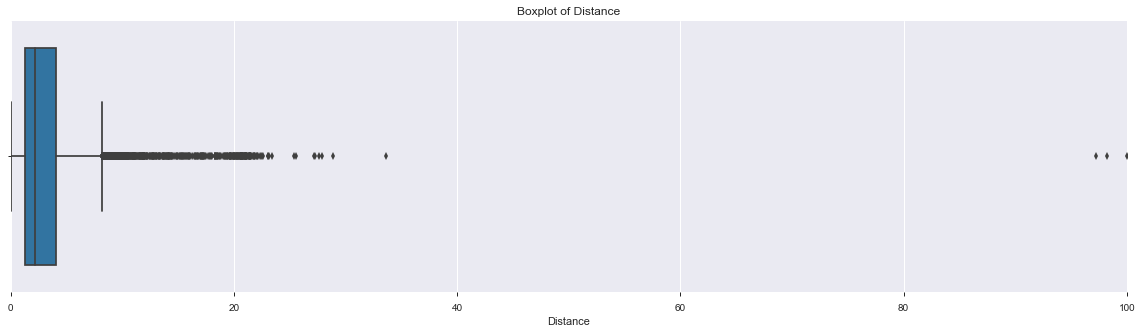

In [70]:
# Plotting a box plot as it is best to visualize outliers:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=d_test['Distance'],data=d_test,orient='h')
plt.title('Boxplot of Distance')
# plt.savefig('bp of fare_amount.png')
plt.show()


In [71]:
d_test['Distance'].sort_values(ascending=True)


6335     0.000000
7637     0.000000
2258     0.000000
943      0.000000
8835     0.000000
860      0.000000
9221     0.000000
6157     0.000000
2936     0.000000
2247     0.000000
1189     0.000000
318      0.000000
491      0.000000
8424     0.000000
8426     0.000000
5443     0.000000
498      0.000000
2618     0.000000
976      0.000000
6954     0.000000
7874     0.000000
1409     0.000000
2675     0.000000
981      0.000000
451      0.000000
7839     0.000000
1429     0.000000
1218     0.000000
2641     0.000000
121      0.000000
          ...    
4018    21.738063
7857    21.782684
8944    21.785143
8876    21.811484
7000    21.845869
5523    21.880030
628     21.880433
6260    22.064573
7346    22.080922
8825    22.113966
5373    22.132067
248     22.344419
2718    22.407984
7787    22.474632
8173    22.640229
2175    23.051119
5905    23.099448
5357    23.120250
5865    23.443658
2487    25.364627
706     25.565980
4864    27.169511
9391    27.287881
5115    27.653128
3569    27

In [72]:
# 6 and 7 value corresponds to Saturday and Sunday.
d_test['Day'] = (d_test['Day'] <= 5).astype(int)
d_test.head()

,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance
0,1,2015,1,27,1,13,8,2.323259
1,1,2015,1,27,1,13,8,2.425353
2,1,2011,10,8,1,11,53,0.618628
3,1,2012,12,1,1,21,12,1.961033
4,1,2012,12,1,1,21,12,5.387301


Text(0.5, 1.0, 'Correlation between features')

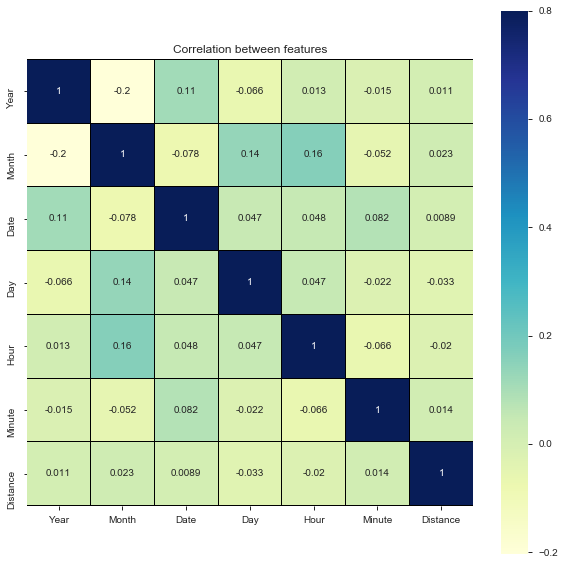

In [73]:
corr = d_test[d_test.columns[1:]].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.title('Correlation between features')


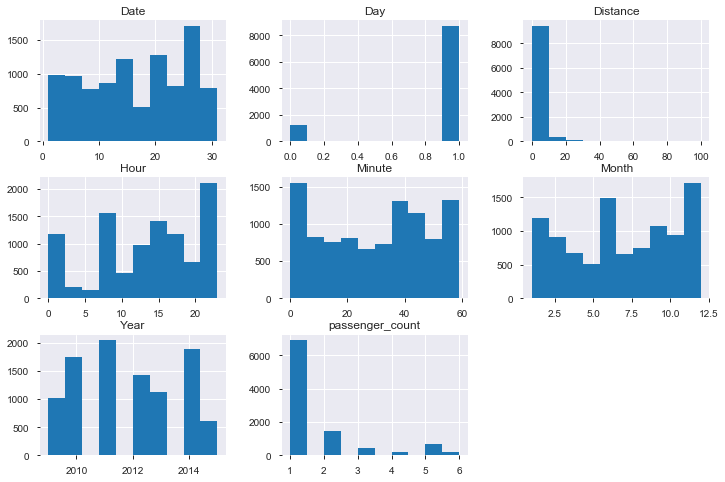

In [74]:
d_test.hist(figsize=(12, 8))
plt.show()


In [76]:
#since skewness of distance variable is high, apply log transform to reduce the skewness-
d_test['Distance'] = np.log1p(d_test['Distance'])

### Predictions on Test data:

In [78]:
## Grid Search CV for random Forest model
regr = RandomForestRegressor(random_state = 0)
n_estimator = list(range(11,20,1))
depth = list(range(5,15,2))

# Create the grid
grid = {'n_estimators': n_estimator,
               'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_rf = GridSearchCV(regr, param_grid = grid, cv = 5)
gridcv_rf = gridcv_rf.fit(X_train,y_train)
view_best_params_GRF = gridcv_rf.best_params_

#Apply model on test data
predictions_GRF_test_Df = gridcv_rf.predict(d_test)

In [79]:
d_test['Predicted_fare'] = predictions_GRF_test_Df

In [80]:
d_test.head()

,passenger_count,Year,Month,Date,Day,Hour,Minute,Distance,Predicted_fare
0,1,2015,1,27,1,13,8,1.200946,1.485735
1,1,2015,1,27,1,13,8,1.231205,1.504576
2,1,2011,10,8,1,11,53,0.481579,1.025012
3,1,2012,12,1,1,21,12,1.085538,1.358884
4,1,2012,12,1,1,21,12,1.854312,0.955497


In [81]:
d_test.to_csv('test.csv')